<a href="https://colab.research.google.com/github/chegermiller/elwha-dgs/blob/main/seg_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!{sys.executable} -m pip install segmenteverygrain
!{sys.executable} -m pip install rtree
import segmenteverygrain as seg
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import cv2
from skimage import measure
!{sys.executable} -m pip install tf_keras
TF_USE_LEGACY_KERAS=True
from tf_keras.optimizers.legacy import Adam
from tf_keras.preprocessing.image import load_img
from importlib import reload
from tqdm import trange

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-n87isyxd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-n87isyxd
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=45a478c3756232f9fb6a73aec204dc71716c08d9ccc60153155f255ad3553f7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-4_eo7d87/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 12.6 MB/s eta 0:00:00


In [2]:
import keras
from keras.saving import load_model
print(keras.__version__)

3.8.0


In [3]:
model_fname = "/content/drive/MyDrive/Research Personal/seg_model.keras"
model = load_model(model_fname, custom_objects={'weighted_crossentropy': seg.weighted_crossentropy})
sam = sam_model_registry["default"](checkpoint="/content/drive/MyDrive/Research Personal/sam_vit_h_4b8939.pth")

In [4]:
fname = "/content/drive/MyDrive/Research Personal/132_2014_05_17_450.JPG"
image = np.array(load_img(fname))

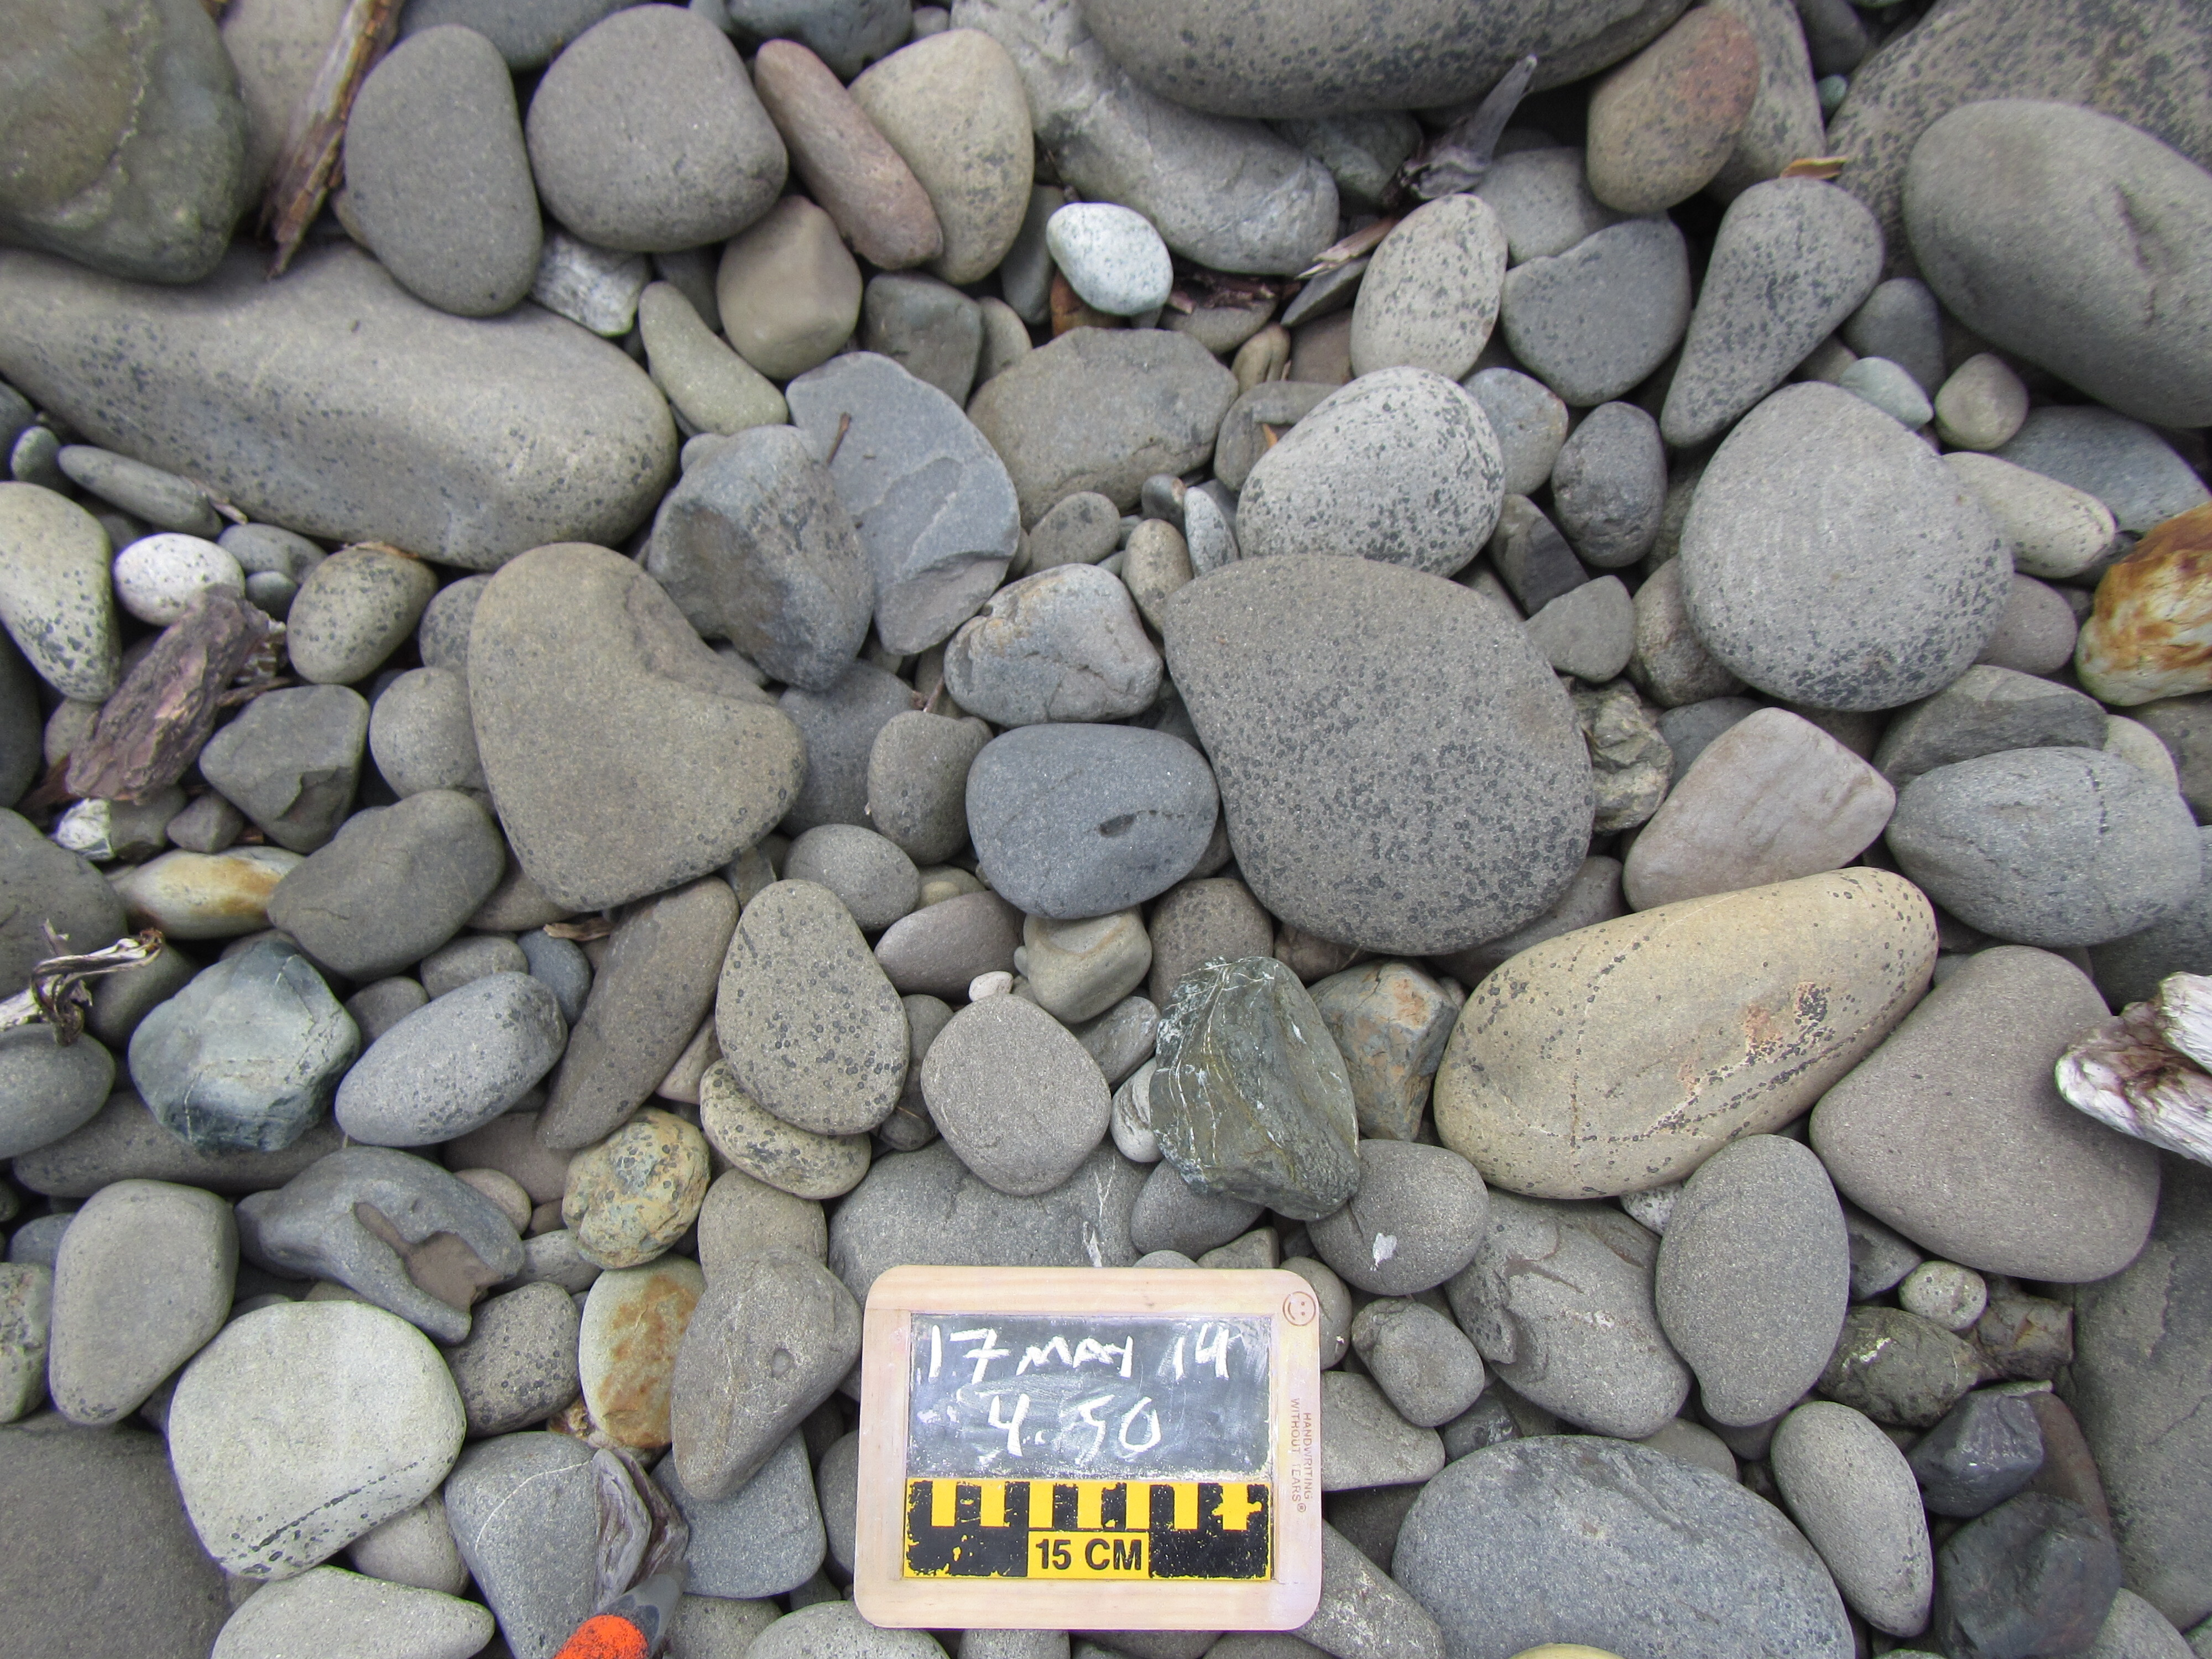

In [8]:
from IPython.display import Image
Image(filename=fname)

In [5]:
image_pred = seg.predict_image(image, model, I=256)
labels, coords = seg.label_grains(image, image_pred, dbs_max_dist=20.0)

segmenting image tiles...


100%|██████████| 16/16 [00:32<00:00,  2.02s/it]


([], [])

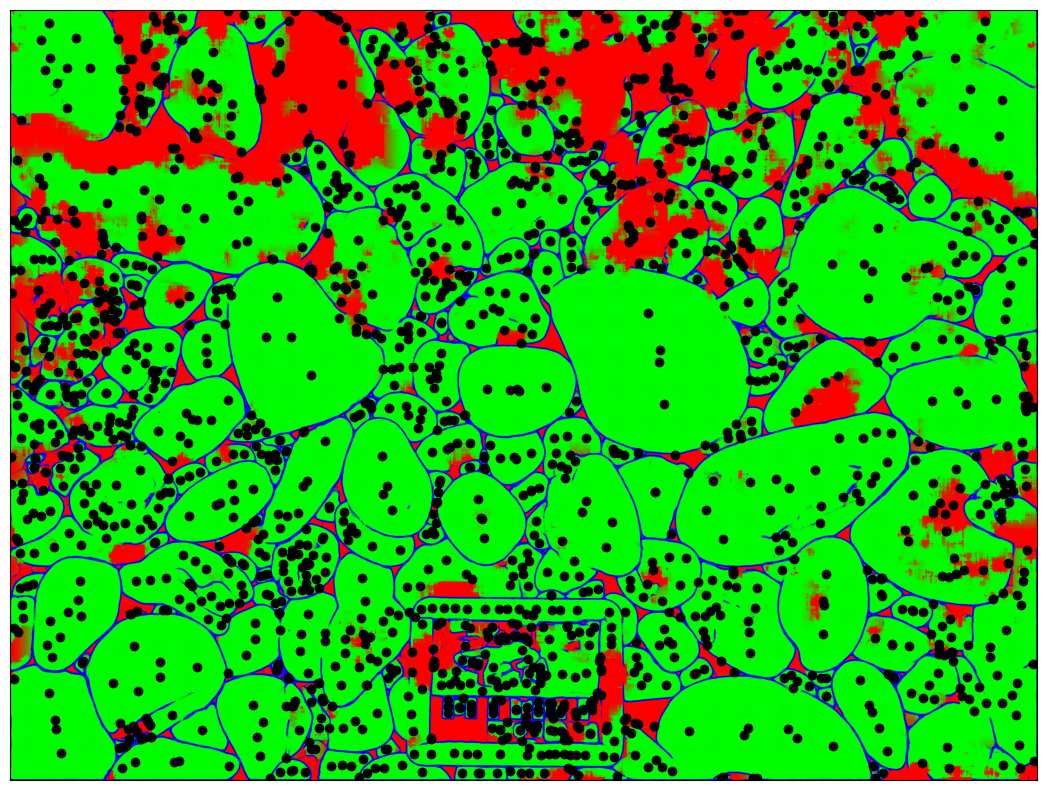

In [6]:
plt.figure(figsize=(15,10))
plt.imshow(image_pred)
plt.scatter(np.array(coords)[:,0], np.array(coords)[:,1], c='k')
plt.xticks([])
plt.yticks([])

creating masks using SAM...


100%|██████████| 1864/1864 [44:11<00:00,  1.42s/it]


finding overlapping polygons...


1527it [06:20,  4.02it/s]


finding best polygons...


100%|██████████| 192/192 [05:34<00:00,  1.74s/it]


creating labeled image...


100%|██████████| 222/222 [00:06<00:00, 31.96it/s]


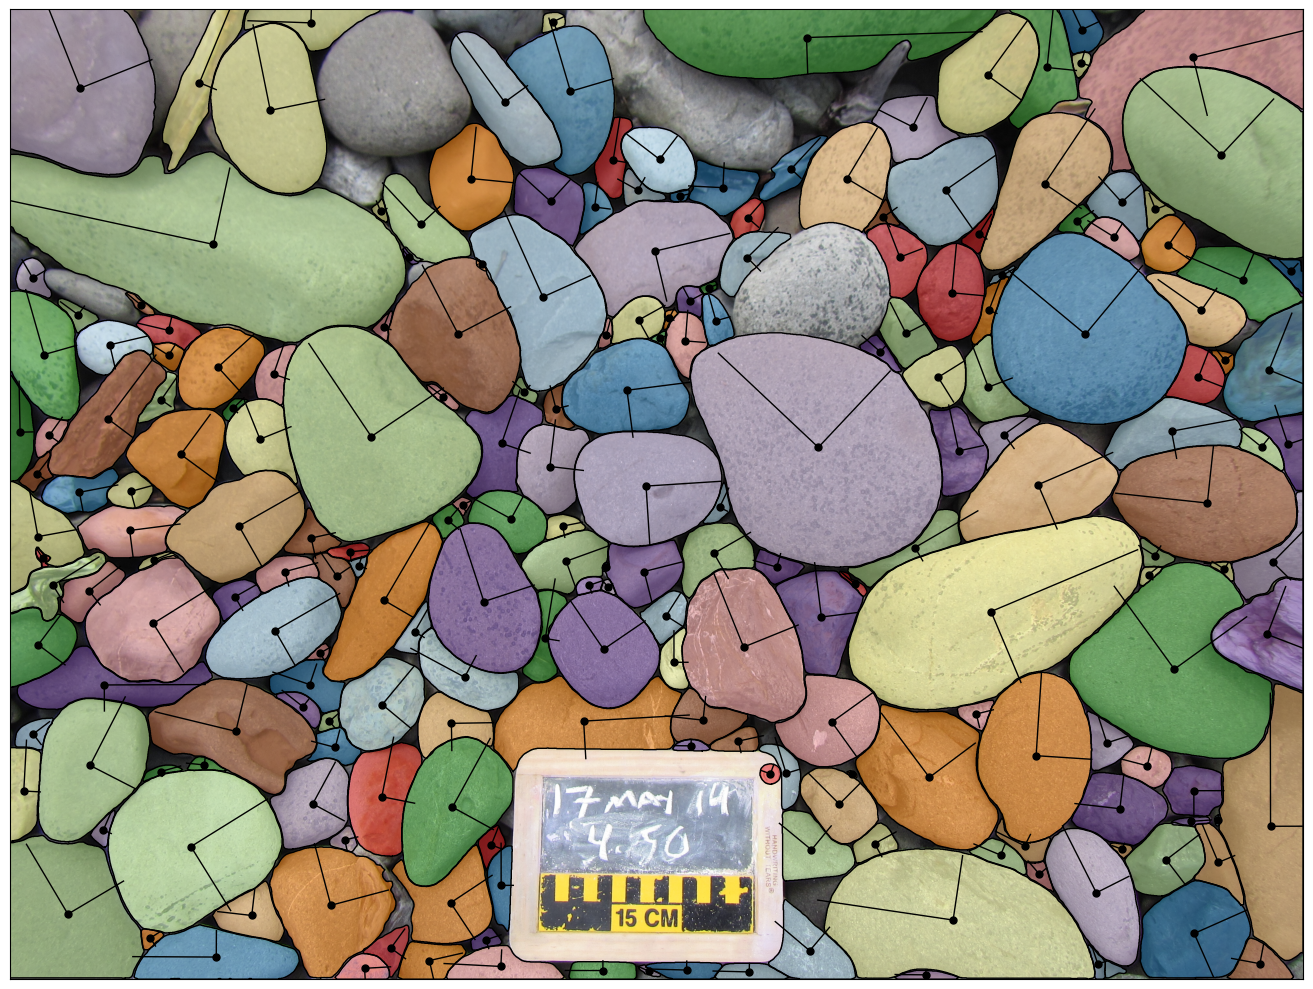

In [7]:
# SAM segmentation, using the point prompts from the Unet:
all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(sam, image, image_pred,
            coords, labels, min_area=400.0, plot_image=True, remove_edge_grains=False, remove_large_objects=False)

In [23]:
grain_data

label      area   centroid-0   centroid-1  major_axis_length  \
0        1    3920.0   644.101531  2700.760459         104.121807   
1        2   29118.0  2209.294972  1365.154853         259.753853   
2        3   14329.0  2710.406937  1519.057366         260.372998   
3        4   24228.0  2803.521463   747.745460         211.704179   
4        5    5459.0   619.854918  3542.721744         105.593346   
..     ...       ...          ...          ...                ...   
217    218   18480.0  1308.749405    31.256277         314.652937   
218    219  111338.0  1471.155787  3179.585460         502.199090   
219    220    6060.0  1437.464356    84.407426         129.065209   
220    221    2923.0  2953.749914  3364.494355         111.059130   
221    222    2066.0  2971.583253  3411.353340          68.038235   

     minor_axis_length  orientation    perimeter  max_intensity-0  \
0            72.528748    -0.952385   351.232539            114.0   
1           168.191560    -1.555126   786.724963            223.0   
2            75.051242     0.001673   608.048773            192.0   
3           163.226741     1.457472   675.168614            214.0   
4            84.395674     0.379662   354.776695             66.0   
..                 ...          ...          ...              ...   
217          80.158721     0.020039   726.534055             82.0   
218         297.849451    -1.163692  1395.231673            215.0   
219          67.431284    -0.656042   372.658946            131.0   
220          37.849074     0.325552   271.965512             90.0   
221          45.891965     1.476874   204.610173             87.0   

     max_intensity-1  max_intensity-2  mean_intensity-0  mean_intensity-1  \
0              117.0            120.0         42.140561         40.889796   
1              221.0            206.0        152.204753        148.892472   
2              188.0            189.0        102.282434        103.049271   
3              214.0            206.0        135.666997        134.731426   
4               72.0             65.0         36.329181         35.280454   
..               ...              ...               ...               ...   
217             85.0             85.0         47.296374         48.748377   
218            211.0            212.0        160.142386        154.879538   
219            109.0            126.0         46.480363         37.771617   
220             79.0            114.0         32.995553         29.164899   
221            110.0             90.0         33.404163         35.306873   

     mean_intensity-2  min_intensity-0  min_intensity-1  min_intensity-2  
0           42.830357             13.0             12.0             11.0  
1          136.046500             43.0             42.0             29.0  
2          105.165608             10.0             14.0              5.0  
3          131.966857             19.0             21.0             27.0  
4           34.493497             19.0             19.0             17.0  
..                ...              ...              ...              ...  
217         46.778788             12.0             12.0             10.0  
218        151.878334             20.0             20.0             18.0  
219         38.163531             10.0             10.0             11.0  
220         35.187821              9.0              2.0              9.0  
221         33.174734              8.0             11.0              4.0  

[222 rows x 17 columns]

In [42]:
grain_data[["label", "minor_axis_length"]]

label  minor_axis_length
0        1          72.528748
1        2         168.191560
2        3          75.051242
3        4         163.226741
4        5          84.395674
..     ...                ...
217    218          80.158721
218    219         297.849451
219    220          67.431284
220    221          37.849074
221    222          45.891965

[222 rows x 2 columns]

from matplotlib import pyplot as plt
_df_0['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['minor_axis_length'].plot(kind='hist', bins=20, title='minor_axis_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='label', y='minor_axis_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['label']
  ys = series['minor_axis_length']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('minor_axis_length')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['label']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'label'}, axis=1)
              .sort_values('label', ascending=True))
  xs = counted['label']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('label', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('label')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['minor_axis_length'].plot(kind='line', figsize=(8, 4), title='minor_axis_length')
plt.gca().spines[['top', 'right']].set_visible(False)

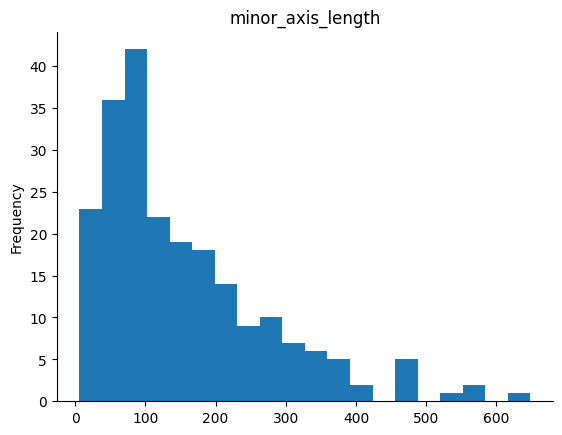

In [58]:
from matplotlib import pyplot as plt
_df_1['minor_axis_length'].plot(kind='hist', bins=20, title='minor_axis_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [56]:
grain_data[["centroid-0", "centroid-1"]]

centroid-0   centroid-1
0     644.101531  2700.760459
1    2209.294972  1365.154853
2    2710.406937  1519.057366
3    2803.521463   747.745460
4     619.854918  3542.721744
..           ...          ...
217  1308.749405    31.256277
218  1471.155787  3179.585460
219  1437.464356    84.407426
220  2953.749914  3364.494355
221  2971.583253  3411.353340

[222 rows x 2 columns]

In [61]:
grain_data[grain_data["minor_axis_length"] > 600]

label      area   centroid-0   centroid-1  major_axis_length  \
77     78  427644.0  1355.735037  2499.948403         850.039741   

    minor_axis_length  orientation    perimeter  max_intensity-0  \
77         648.339498     0.815486  2543.915006            255.0   

    max_intensity-1  max_intensity-2  mean_intensity-0  mean_intensity-1  \
77            254.0            255.0        137.666734        138.240719   

    mean_intensity-2  min_intensity-0  min_intensity-1  min_intensity-2  
77        137.877057             28.0             40.0             36.0

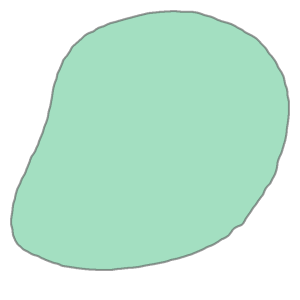

In [62]:
all_grains[77]